See also [Linear Regression section](https://exhbma.readthedocs.io/en/latest/linear_regression.html) in the documentation.

In [1]:
import logging

import numpy as np

from exhbma import (
    ExhaustiveLinearRegression,
    inverse,
    StandardScaler,
    feature_posterior,
    weight_diagram,
    sigma_posterior,
)

In [2]:
log_level = logging.INFO
logger = logging.getLogger(__name__)
logger.propagate = False
handler = logging.StreamHandler()
handler_format = logging.Formatter(
    fmt="%(levelname)s %(asctime)s [%(name)s]: %(message)s",
    datefmt="%Y-%m-%dT%H:%M:%S%z",
)
handler.setFormatter(handler_format)
handler.setLevel(log_level)
logger.setLevel(log_level)
logger.addHandler(handler)

# Generate sample dataset

In [3]:
n_data, n_features = 50, 10
sigma_noise = 0.1

nonzero_w = [1, 1, -0.8, 0.5]
w = nonzero_w + [0] * (n_features - len(nonzero_w))

np.random.seed(0)
X = np.random.randn(n_data, n_features)
y = np.dot(X, w) + sigma_noise * np.random.randn(n_data)

# Train a model

In [4]:
# Data preprocessing
x_scaler = StandardScaler(n_dim=2)
y_scaler = StandardScaler(n_dim=1, scaling=False)
x_scaler.fit(X)
y_scaler.fit(y)
X = x_scaler.transform(X)
y = y_scaler.transform(y)

In [5]:
# Settings of prior distributions for sigma_noise and sigma_coef
n_sigma_points = 20
sigma_noise_log_range = [-2.5, 0.5]
sigma_coef_log_range = [-2, 1]

# Model fitting
reg = ExhaustiveLinearRegression(
    sigma_noise_points=inverse(
        np.logspace(sigma_noise_log_range[0], sigma_noise_log_range[1], n_sigma_points),
    ),
    sigma_coef_points=inverse(
        np.logspace(sigma_coef_log_range[0], sigma_coef_log_range[1], n_sigma_points),
    ),
)
reg.fit(X, y)

100%|██████████| 1024/1024 [00:26<00:00, 38.80it/s]


# Results

In [6]:
columns = [f"feat: {i}" for i in range(n_features)]

## Feature posterior

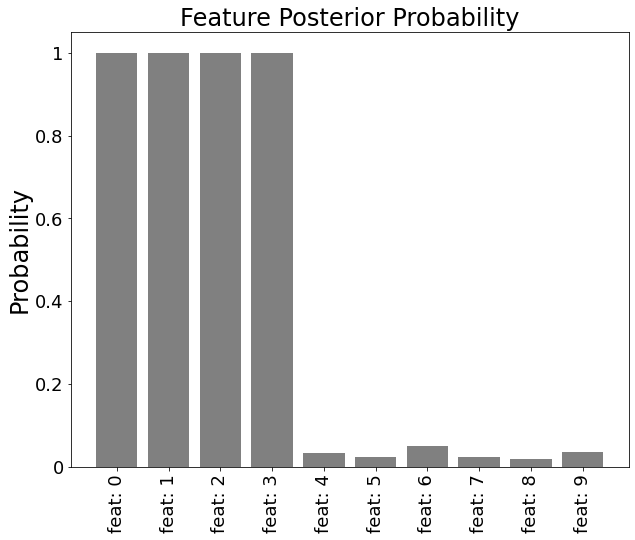

In [7]:
fig, ax = feature_posterior(
    model=reg,
    title="Feature Posterior Probability",
    ylabel="Probability",
    xticklabels=columns,
)

## Sigma posterior distribution

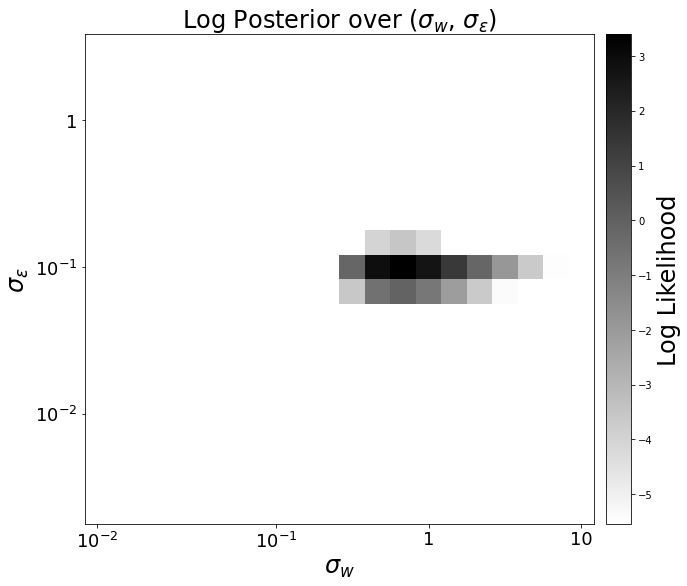

In [8]:
fig, ax = sigma_posterior(
    model=reg,
    title="Log Posterior over ($\sigma_{w}$, $\sigma_{\epsilon}$)",
    xlabel="$\sigma_{w}$",
    ylabel="$\sigma_{\epsilon}$",
    cbarlabel="Log Likelihood",
)

## Coefficient

In [9]:
for i, c in enumerate(reg.coef_):
    logger.info(f"Coefficient of feature {i}: {c:.4f}")

INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 0: 1.0072
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 1: 0.9766
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 2: -0.7500
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 3: 0.5116
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 4: -0.0006
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 5: -0.0002
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 6: 0.0012
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 7: 0.0003
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 8: -0.0000
INFO 2022-07-25T11:54:09+0900 [__main__]: Coefficient of feature 9: 0.0007


## Weight diagram

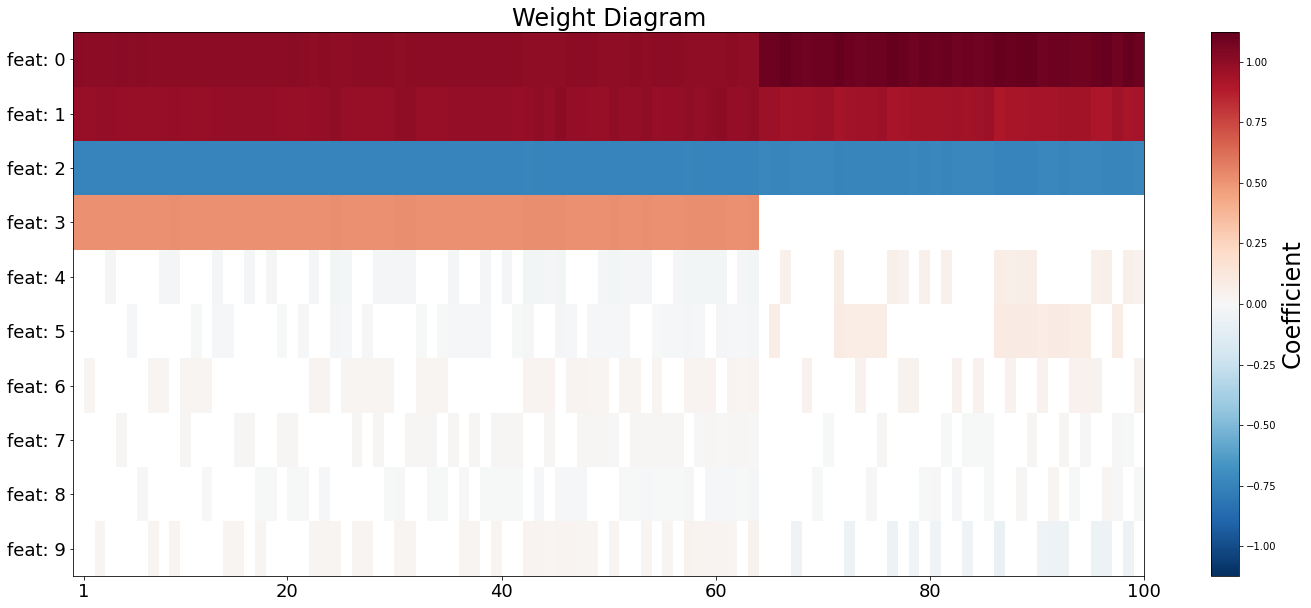

In [10]:
fig, ax = weight_diagram(
    model=reg,
    yticklabels=columns,
    title="Weight Diagram",
    cbarlabel="Coefficient",
)

# Prediction for new data

In [11]:
n_test = 10**3

np.random.seed(10)
test_X = np.random.randn(n_test, n_features)
test_y = np.dot(test_X, w) + sigma_noise * np.random.randn(n_test)

In [12]:
# RMSE for test data

pred_y = y_scaler.restore(
    reg.predict(x_scaler.transform(test_X), mode="full")
)
rmse = np.power(test_y - pred_y, 2).mean() ** 0.5
logger.info(f"RMSE for test data: {rmse:.4f}")

INFO 2022-07-25T11:54:09+0900 [__main__]: RMSE for test data: 0.1029
